## Diffusers Library


There are three main components of the library:

1. The `DiffusionPipeline` is a high-level end-to-end class designed to rapidly generate samples from pretrained diffusion models for inference.
2. Popular `pretrained model architectures` and modules that can be used as building blocks for creating diffusion systems.
3. `Schedulers` - algorithms that control how noise is added for training, and how to generate denoised images during inference.

In this notebook we shall learn

* how to generate images using text prompts
* the various diffusion pipelines for tasks such as text-to-image, image-to-image, text-to-music
* primary components of the diffusion pipeline: UNet model and schedulers

In [2]:
#diffusers is a hugging face page for using diffusion models from huggingface hub
!pip install -qqq diffusers transformers accelerate

# Accelerate speeds up model loading for inference and training.
# Transformers is required to run the most popular diffusion models, such as Stable Diffusion.

In [1]:
!pip show torch

Name: torch
Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision


In [2]:
from diffusers import DiffusionPipeline
import torch
from PIL import Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Text-to-Image Generation using Stable Diffusion and Diffusers


In [ ]:
# Load the Stable Diffusion pipeline
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe = pipe.to("cuda") # move the generator object to a GPU

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

To know more parameters for generation interface [click here](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_xl#diffusers.StableDiffusionXLPipeline.__call__)

In [ ]:
def generate_image_interface(prompt, negative_prompt, num_inference_steps=50, weight=1024):
  params = {'prompt': prompt, 'num_inference_steps': num_inference_steps, 'num_images_per_prompt':1, 'height':int(weight),
            'weight': weight, 'negative_prompt': negative_prompt}

  img = pipe(**params).images
  return img[0]   #By default, the image output is wrapped in a PIL.Image object.

In [ ]:
image = generate_image_interface("A Yogi doing yoga", "low quality, distorted", 100)

  0%|          | 0/100 [00:00<?, ?it/s]

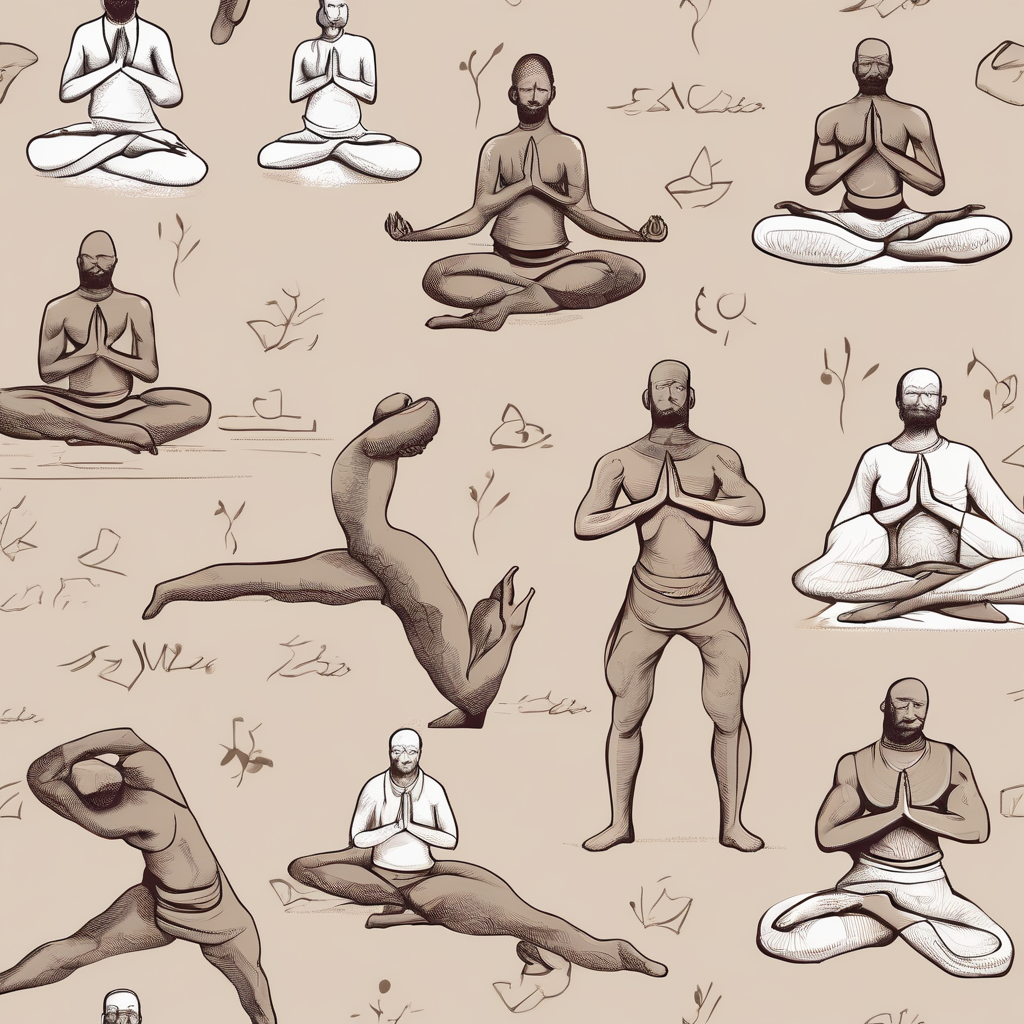

In [ ]:
display(image)

In [ ]:
image.save("yogi.png") # save the image

### Scheduler swapping

Different schedulers come with different denoising speeds and quality trade-offs.

To swap the schedular:

In [ ]:
from diffusers import PNDMScheduler
pipe.scheduler = PNDMScheduler.from_config(pipe.scheduler.config)

In [ ]:
image = generate_image_interface("A Yogi doing yoga", "low quality, distorted", 100)

  0%|          | 0/100 [00:00<?, ?it/s]

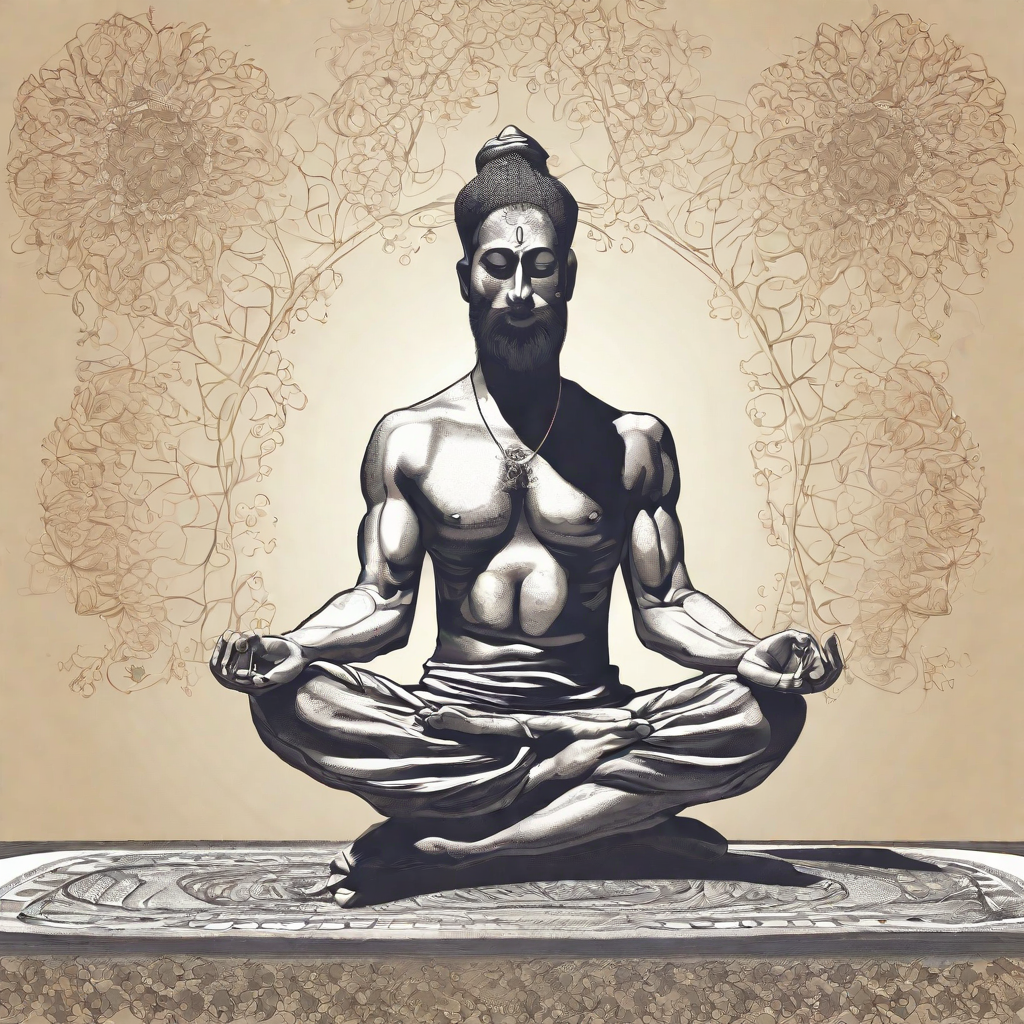

In [ ]:
display(image)

In [ ]:
image.save("yogi_1.png") # save the image

## Image to Image

Image-to-image is similar to text-to-image, but in addition to a prompt, you can also pass an initial image as a starting point for the diffusion process. The initial image is encoded to latent space and noise is added to it. Then the latent diffusion model takes a prompt and the noisy latent image, predicts the added noise, and removes the predicted noise from the initial latent image to get the new latent image. Lastly, a decoder decodes the new latent image back into an image.

In [10]:
import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid

model_id = "stabilityai/stable-diffusion-xl-base-1.0"

pipeline = AutoPipelineForImage2Image.from_pretrained(
    model_id, torch_dtype=torch.float16, use_safetensors=True,variant="fp16"
)
pipeline.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": false,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [11]:
# prepare image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-init.png"
init_image = load_image(url)

In [14]:
prompt = "Astronaut in a Den, Dark color palette, detailed, 8k"

  0%|          | 0/15 [00:00<?, ?it/s]

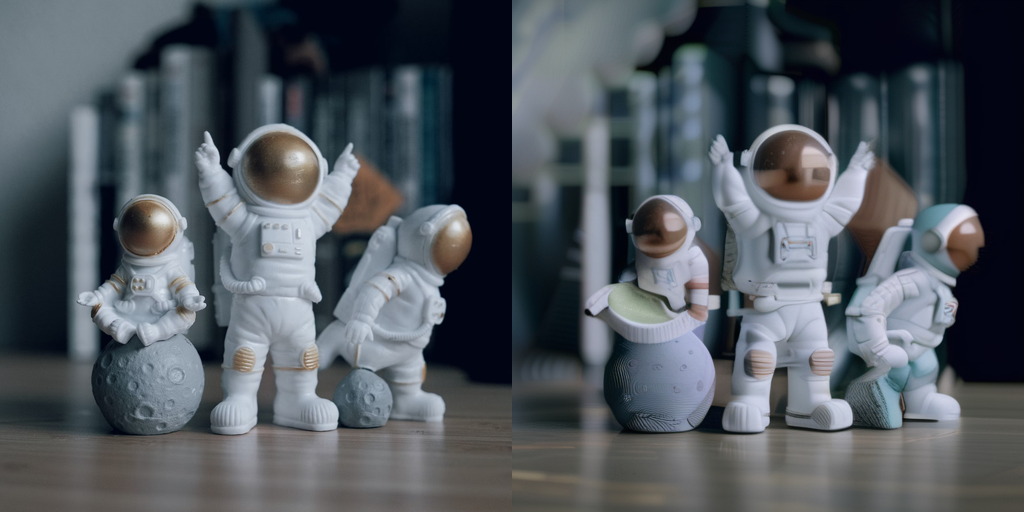

In [15]:
image = pipeline(prompt, image=init_image).images[0]
make_image_grid([init_image, image], rows=1, cols=2)

[More parameters](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_xl#diffusers.StableDiffusionXLImg2ImgPipeline.__call__)

  0%|          | 0/80 [00:00<?, ?it/s]

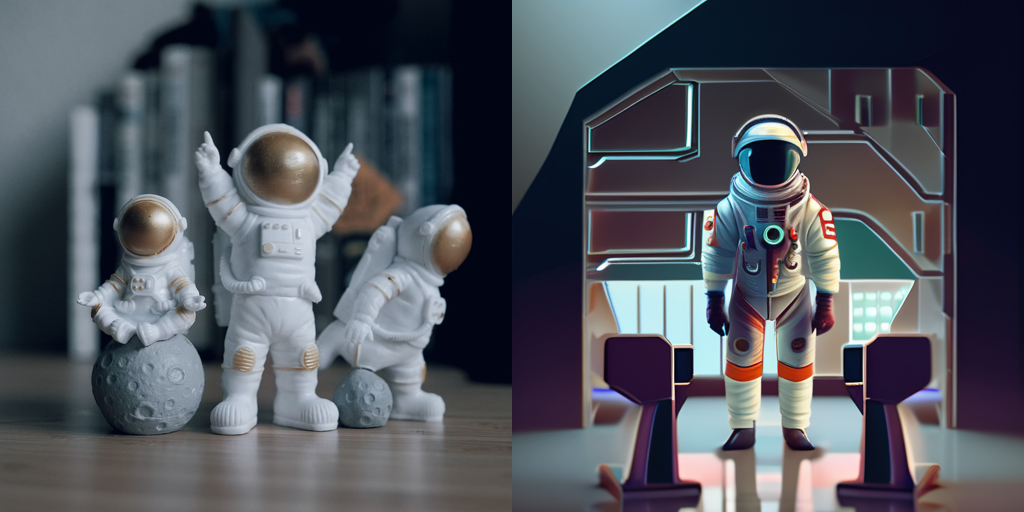

In [19]:
# changing inferece steps and strength
image = pipeline(prompt, image=init_image,strength = 0.8,num_inference_steps=100).images[0]
make_image_grid([init_image, image], rows=1, cols=2)

## Text-guided depth-to-image generation

The StableDiffusionDepth2ImgPipeline lets you `pass a text prompt` and an `initial image to condition the generation of new images`. In addition, you can also pass a depth_map to preserve the image structure. If no depth_map is provided, the pipeline automatically predicts the depth via an integrated depth-estimation model.

In [1]:
import torch
from diffusers import StableDiffusionDepth2ImgPipeline
from diffusers.utils import load_image, make_image_grid

pipeline = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    torch_dtype=torch.float16,
    use_safetensors=True,
).to("cuda")

model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/490M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

depth_estimator/config.json:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/923 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
# prepare image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-init.png"
init_image = load_image(url)

  0%|          | 0/70 [00:00<?, ?it/s]

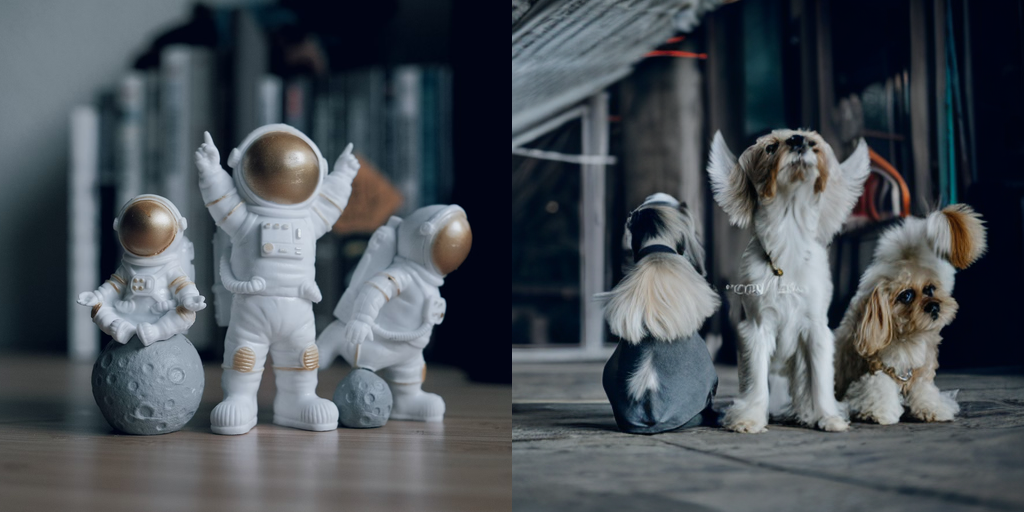

In [4]:
prompt = "three dogs"
negative_prompt = "bad, deformed, ugly, bad anatomy"
image = pipeline(prompt=prompt, image=init_image, negative_prompt=negative_prompt, strength=0.7,num_inference_steps=100).images[0]
make_image_grid([init_image, image], rows=1, cols=2)